In [10]:

# xgboost для регрессии
from numpy import asarray
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from src.drawing import show_forecast_test_plot, show_time_series_only, show_acf_pacf
from src.statistic import check_stationarity, make_diff_n_degree

In [11]:
ts = pd.read_csv('train.csv')
ts['Date'] = pd.to_datetime(ts['Date'])

In [12]:
def create_date_features(df):
    df['month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['day_of_week'] = df.Date.dt.dayofweek + 1
    df['year'] = df.Date.dt.year
    df["is_wknd"] = df.Date.dt.weekday // 4
    df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    return df

ts = create_date_features(ts)

def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['lag_' + str(lag)] = dataframe['target_value'].transform(
            lambda x: x.shift(lag))
    return dataframe

ts = lag_features(ts, [1, 2, 3, 4, 5, 7, 10])

def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['mean_' + str(window)] = dataframe['target_value'].transform(lambda x:
                                                                               x.shift(1).rolling(window=window, min_periods=1, win_type="triang").mean())
    return dataframe
ts = roll_mean_features(ts, [1, 2, 7, 14, 30])

def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['target_value']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [1, 2, 3, 4, 5, 7, 10]
ts = ewm_features(ts, alphas, lags)
ts = pd.get_dummies(ts, columns=[ 'day_of_week', 'month'])

ts['target_value'] = np.log1p(ts["target_value"].values)

In [13]:
time = ts.Date
target = ts.target_value
TRAIN_SIZE = len(target) - 7
train, test = train_test_split(ts, train_size=TRAIN_SIZE, shuffle=False)

show_time_series_only(time, target)
test_values = target[TRAIN_SIZE:]

In [16]:
# def create_features(df, label=None):
#     """
#     Creates time series features from datetime index
#     """
#
#     df['date'] = df.Date
#     df['hour'] = df['date'].dt.hour
#     df['dayofweek'] = df['date'].dt.dayofweek
#     df['quarter'] = df['date'].dt.quarter
#     df['month'] = df['date'].dt.month
#     df['year'] = df['date'].dt.year
#     df['dayofyear'] = df['date'].dt.dayofyear
#     df['dayofmonth'] = df['date'].dt.day
#
#
#     X = df[['hour','dayofweek','quarter','month','year',
#            'dayofyear','dayofmonth']]
#     if label:
#         y = df[label]
#         return X, y
#     return X

X_train = train.drop(['Date', 'target_value'], axis=1)
y_train = train.target_value
X_test =test.drop(['Date', 'target_value'], axis=1)
y_test = test.target_value

In [17]:
reg = XGBRegressor(n_estimators=100)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train
'''
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)
'''

C:\Users\Osipov\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



"\nXGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,\n       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,\n       importance_type='gain', interaction_constraints=None,\n       learning_rate=0.300000012, max_delta_step=0, max_depth=6,\n       min_child_weight=1, missing=nan, monotone_constraints=None,\n       n_estimators=100, n_jobs=0, num_parallel_tree=1,\n       objective='reg:squarederror', random_state=0, reg_alpha=0,\n       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,\n       validate_parameters=False, verbosity=None)\n"

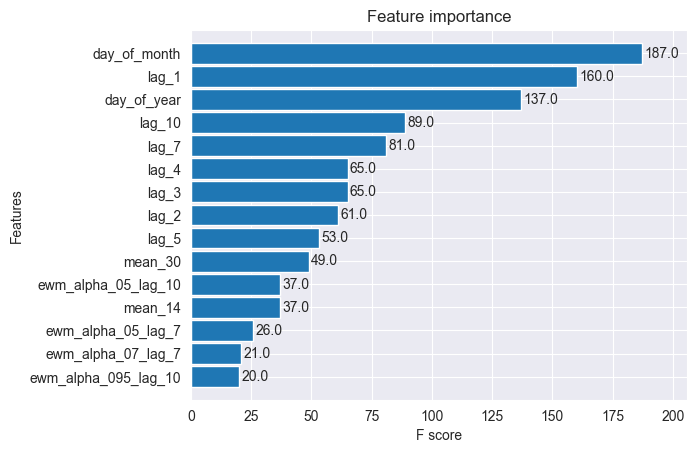

In [21]:
_ = xgb.plot_importance(reg, height=0.9, max_num_features=15)

In [19]:
forecast = reg.predict(X_test)
print(forecast)
print(test_values)

[7.167334  7.167334  7.167334  7.107749  7.0546527 7.048011  7.047294 ]
359    7.182359
360    7.161445
361    7.105261
362    7.072514
363    7.079540
364    7.070880
365    7.082795
Name: target_value, dtype: float64


In [20]:
train.target_value = np.expm1(train.target_value)
forecast = np.expm1(forecast)
test_values = np.expm1(test_values)
show_forecast_test_plot(time, train.target_value, forecast, test_values)
